In [8]:
from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO
%load_ext autoreload
%autoreload 2

print('SB3 vestsion:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SB3 vestsion: 1.7.0
Using device: cpu


---
### Environment test and visualization:

In [15]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(nelx=100,nely=50,mode='train',observation_type='image'))

In [16]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(nelx=100,nely=50,mode='train',observation_type='image')
eval_env = sogym(nelx=100,nely=50,mode='test',observation_type='image')

In [17]:
# The training environment and the eval environment both have a different boundary conditions distribution:
print("Number of unique BC + desired volume frac combinations in the train distribution: ",len(train_env.BC_dict))
print("Number of unique BC + desired volume frac combinations in the test distribution: ",len(eval_env.BC_dict))

Number of unique BC + desired volume frac combinations in the train distribution:  4284
Number of unique BC + desired volume frac combinations in the test distribution:  2412


In [18]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward<=0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
train_env.check_connec()

True

In [ ]:
obs = train_env.reset()

In [ ]:
train_env.compliance

84.33288893629688

Volume:  0.5798701633245363
Reward  0.0


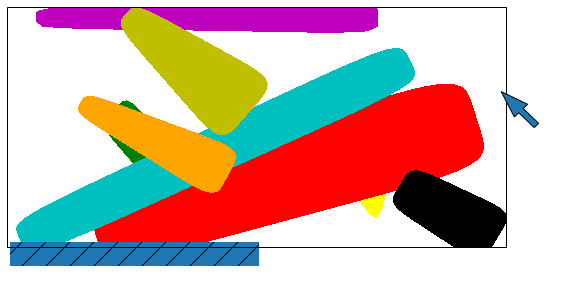

In [ ]:
action = train_env.action_space.sample()
obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot(train_viz=False)

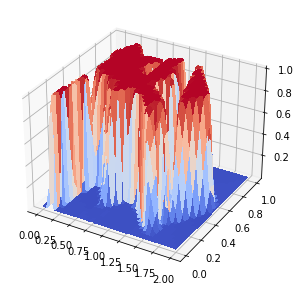

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#surf = ax.plot_surface(train_env.x, train_env.y, train_env.Phi[:,5].reshape((train_env.nely+1,train_env.nelx+1),order='F'), cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

    
surf = ax.plot_surface(train_env.x, train_env.y, train_env.H.reshape((train_env.nely+1,train_env.nelx+1),order='F'), cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
# Make data.
#train_env.Phi

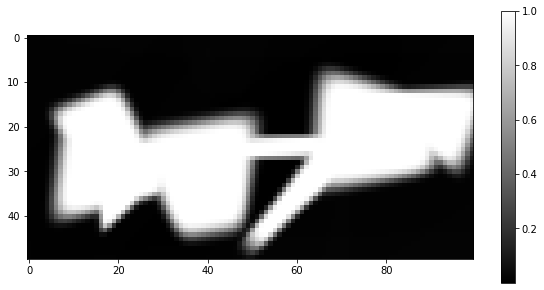

In [ ]:
# Plot the density:
plt.imshow(train_env.den.reshape((train_env.nely,train_env.nelx),order='F'),cmap='gray')
plt.colorbar()

In [ ]:
import cv2

# Load grayscale image
img = (train_env.den.reshape((train_env.nely,train_env.nelx),order='F'))


# Threshold the image to create a binary image with dark pixels as 1s and light pixels as 0s
thresh = cv2.threshold(img,0.1, 255, cv2.THRESH_BINARY)[1]
thresh = np.array(thresh,dtype=np.uint8)

# Apply a connected component analysis to find the connected components in the image
output = cv2.connectedComponentsWithStats(thresh, connectivity=8)



(50, 100)


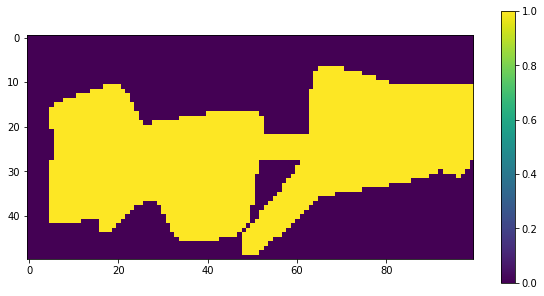

In [ ]:
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

print(labels.shape)
plt.imshow(labels)
plt.colorbar()

In [ ]:
# Let's say we want to know if the load and the support boundaries are connected:
#Relative y position of load
#Relative x position of load
 #Relative y position of support_1
#Relative x position of support_1
#Relative y position of support_2
 #Relative x position of support_2
#Volume fraction (between 0 and 1)
#magnitude of load in x 
#magnitude of load in y 
y_load = int(train_env.out_conditions[0]*(train_env.nely))
x_load = int(train_env.out_conditions[1]*(train_env.nelx))
y_support_1 = int(train_env.out_conditions[2]*(train_env.nely))
x_support_1 = int(train_env.out_conditions[3]*(train_env.nelx))
y_support_2 = int(train_env.out_conditions[4]*(train_env.nely))
x_support_2 = int(train_env.out_conditions[5]*(train_env.nelx))

#labels of support_1 and support_2
label_support_1 = labels[y_support_1,x_support_1:x_support_2]

#labels of load:
label_load = labels[y_load,x_load]
if label_load != 0:
    if label_load in label_support_1:
        print('connected')
else:
    print('not connected')

not connected


In [ ]:
label_support_1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [ ]:
# I want to index each 1 + 2 element of train_env.U:
U_x = train_env.U[0::2]
U_y = train_env.U[1::2]


(5151, 1)


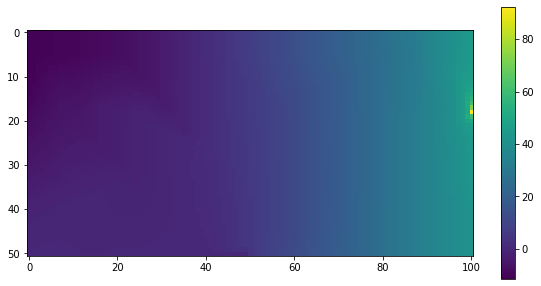

In [ ]:
import matplotlib.pyplot as plt
print(U_x.shape)
plt.imshow(U_y.reshape((train_env.nely+1,train_env.nelx+1),order='F'))
plt.colorbar()


In [ ]:
F_x.nonzero()

(array([5101]), array([0]))

(5151, 1)


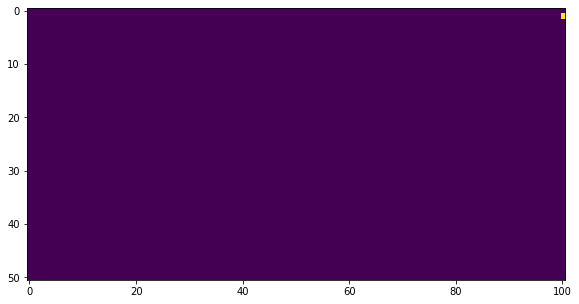

In [ ]:
#Convert train_env.F to a dense matrix:
F_x = train_env.F.toarray()[0::2]
F_y = train_env.F.toarray()[1::2]
print(F_x.shape)
plt.imshow(F_x.reshape((train_env.nely+1,train_env.nelx+1),order='F'))

In [ ]:
# How many elements of F_x are nonzero?
print(F_y.nonzero())

#F_x.reshape((train_env.nely+1,train_env.nelx+1),order='F').nonzero()

(array([5101]), array([0]))


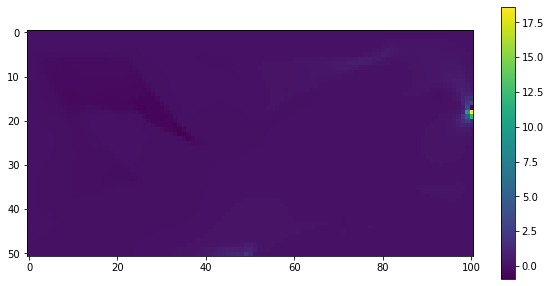

In [ ]:
# LEt's calculate the Von Mises stress from U_x and U_y:
# First, we need to calculate the strain:
# E_xx = dU_x/dx
# E_yy = dU_y/dy
# E_xy = 1/2(dU_x/dy + dU_y/dx)

E_xx = np.gradient(U_x.reshape((train_env.nely+1,train_env.nelx+1),order='F'),axis=1)
E_yy = np.gradient(U_y.reshape((train_env.nely+1,train_env.nelx+1),order='F'),axis=0)
E_xy = 0.5*(np.gradient(U_x.reshape((train_env.nely+1,train_env.nelx+1),order='F'),axis=0) + np.gradient(U_y.reshape((train_env.nely+1,train_env.nelx+1),order='F'),axis=1))

# Now, we can calculate the stress:
# sigma_xx = E_xx*E
# sigma_yy = E_yy*E
# sigma_xy = E_xy*E

plt.imshow(E_xy)
plt.colorbar()

Volume:  0.4979757553332994
Reward  0.0


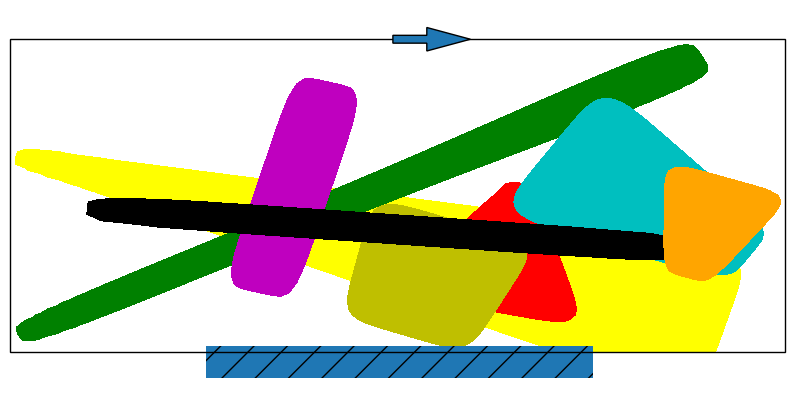

In [ ]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [2]:
num_cpu = 1 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env =VecNormalize(eval_env,gamma=1.0)


In [3]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False,verbose=0)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=2*8*32)])

--- 
### Defining the model

In [4]:
from sogym.utils import ImageDictExtractor
policy_kwargs = dict(
    features_extractor_class=ImageDictExtractor,
    net_arch=[dict(pi=[512,512,512], vf=[512,512,512])],
               optimizer_kwargs={"weight_decay": 1e-3},
    
)

In [5]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            policy_kwargs = policy_kwargs,
            n_steps=32,#(2048*16)//32,  #def: 224
            batch_size=2048*2,#2048*2, #def: 50*224
            verbose=0,
            n_epochs=3,
            vf_coef = 1.0,
            clip_range = 0.3,
            clip_range_vf = 10.0,
            target_kl = 0.02,
            gamma=1.0,  #def: 1
            learning_rate=3e-4,
            ent_coef=3e-4,
            tensorboard_log="tb_logs",
            device='cuda'
            )


/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.9/site-packages/stable_baselines3/ppo/ppo.py:145: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(
/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.9/site-packages/stable_baselines3/common/policies.py:458: UserWarning: As shared layers in the mlp_extractor are deprecated and will be removed in SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


--- 
### Training

In [ ]:
model.learn(100000,callback=callback,tb_log_name='PPO_test_5M_l2_1e2')
model.save('model_saved',)
env.save('env_saved.pkl')

In [ ]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env = VecNormalize.load('env_saved.pkl',eval_env)

model.load('model_saved',env=env,device='cuda')
model.learn(500000,callback=callback,reset_num_timesteps=False,tb_log_name='PPO_test_1M')
model.save('model_saved_1M',)
env.save('env_saved_1M.pkl')

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='test',observation_type='image')
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False
model=model.load('model_saved')
#model.set_env(env)

[[ 1.       -1.        1.        0.918471 -1.       -1.      ]]
[[ 1.        1.        0.575478  1.       -1.       -1.      ]]
[[ 1.          1.          0.87357366  1.         -1.         -1.        ]]
[[ 0.48454762  1.          1.          1.         -1.         -1.        ]]
[[-0.42715895  1.          1.          1.         -1.         -1.        ]]
[[-1.          0.719636    1.          0.69414175 -1.         -1.        ]]
[[-1. -1.  1.  1. -1. -1.]]
[[-1. -1. -1.  1. -1. -1.]]
Reward: 0.0032587978837553887


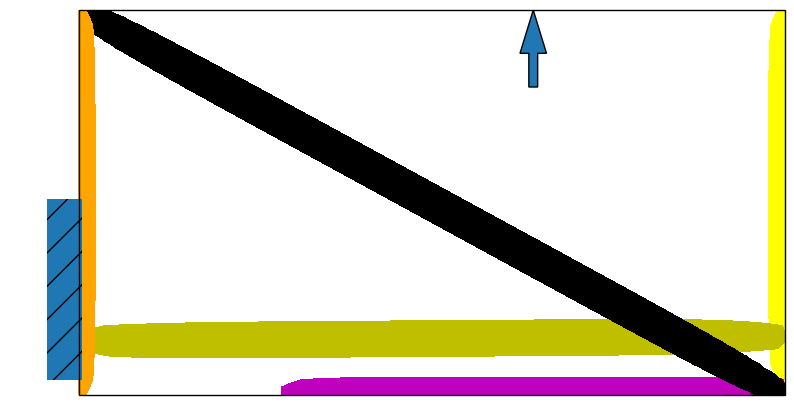

In [ ]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = env.step(action)
  
print("Reward:",rewards[0])
#print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
#fig = env.render()

fig

In [ ]:
1/rewards

array([306.86162066])

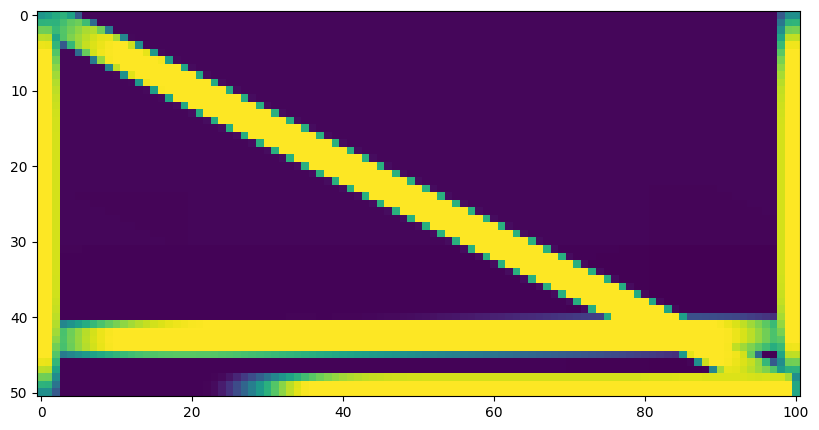

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(env.get_attr('H')[0].reshape((51,101),order='F'))